In [106]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import matplotlib
import matplotlib.pyplot as pyplot # for plotting


import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [53]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')
train['target']=train['Disbursed']
train=train.drop('Disbursed',axis=1)
target = 'Disbursed'
IDcol = 'ID'

In [56]:
data=train.append(test)
data.head(2)

array([  0.,   1.,  nan])

[0]	train-auc:0.759251+0.0167934	test-auc:0.749253+0.0099274
[10]	train-auc:0.841305+0.00571952	test-auc:0.818179+0.0101398
[20]	train-auc:0.860179+0.00373012	test-auc:0.826288+0.0122425
[30]	train-auc:0.870247+0.00361937	test-auc:0.829738+0.0143461
[40]	train-auc:0.877873+0.00217403	test-auc:0.832099+0.0136744
[50]	train-auc:0.884501+0.00118162	test-auc:0.834242+0.0137074
[60]	train-auc:0.890418+0.000867866	test-auc:0.836148+0.013945
[70]	train-auc:0.894865+0.00115043	test-auc:0.83764+0.0138927
[80]	train-auc:0.899121+0.00158845	test-auc:0.839362+0.0124564
[90]	train-auc:0.903823+0.00115142	test-auc:0.839732+0.0119886
[100]	train-auc:0.909229+0.000976705	test-auc:0.841584+0.0107664
[110]	train-auc:0.913561+0.000704834	test-auc:0.841605+0.0107036
[120]	train-auc:0.91772+0.000963367	test-auc:0.84197+0.0103876
[130]	train-auc:0.922033+0.00128618	test-auc:0.84164+0.0100305
[140]	train-auc:0.926028+0.00163053	test-auc:0.841073+0.00978095
[150]	train-auc:0.929274+0.00184643	test-auc:0.84118

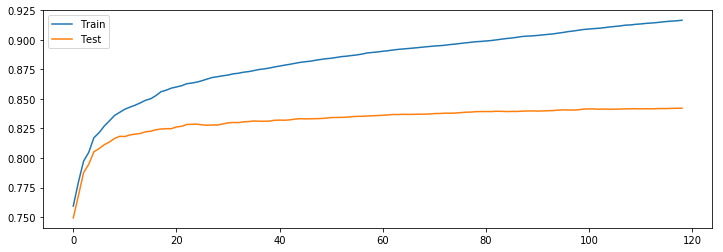

In [118]:
def modelfit(alg, data,features,predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    X = data.loc[~data.target.isna(),features]
    Y = data[~data.target.isna()].target
    X_train, X_test, y_train, y_test = train_test_split( X, Y,test_size = 0.3, random_state = 100,stratify=Y)
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values,label=y_train.values)
        #xgtest = xgb.DMatrix([predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds,verbose_eval=10)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, Y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report(train):
    print("\nModel Report-train")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
    #Predict on testing data:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    #Print model report(test):
    print("\nModel Report-test")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtest_predictions))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))
    
    # plot AUC from train and test set 
    x_axis = range(0, cvresult.shape[0])
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, cvresult['train-auc-mean'], label='Train')
    ax.plot(x_axis, cvresult['test-auc-mean'], label='Test')
    ax.legend()
    pyplot.show()
    
    #Predicting for the test set 
    testD=data.loc[data.target.isna(),features]
    testD['predprob'] = alg.predict_proba(testD)[:,1]
    testD.to_csv("Prediction.csv",index=False)    
                
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    return alg, cvresult, testD 
    
#Choose all predictors except target & IDcols
target = 'target'
IDcol = 'ID'
predictors = [x for x in data.columns if x not in [IDcol]]
features = [x for x in data.columns if x not in [IDcol,target]]
    
alg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

alg,cvresult,testD=modelfit(alg,data,features,predictors)

In [ ]:
#Parameter tunning process 

#1. Tune max_depth and min_child_weight 
#2. Tune gamma 
#3. Again check optimum number of tress (n_estimators) -model run and check accuracy 
#4. T une subsample and colsample_bytree
#5. Tune reg_alpha
#6. Again check optimum number of tress (n_estimators) -model run and check accuracy  for any improvement 
#7. Reduce learning rate and maximize number of trees and run mode again 

In [116]:
#1. Tune max_depth and min_child_weight 
param_test1 = {
 'max_depth':[3,5],
 'min_child_weight':[1,3]
}
estimator=XGBClassifier( learning_rate =0.1, n_estimators=119, gamma=0, subsample=0.8, 
                        colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=3,verbose=30)
gsearch1.fit(train[features],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done   6 out of  12 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed:   48.7s remaining:   34.7s
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:   50.1s remaining:   25.0s
[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed:   55.1s remaining:   18.3s
[Parallel(n_jobs=4)]: Done  10 out of  12 | elapsed:   59.3s remaining:   11.8s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.1min finished


([mean: 0.83032, std: 0.00561, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83216, std: 0.00573, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83474, std: 0.00821, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.83588, std: 0.00780, params: {'max_depth': 5, 'min_child_weight': 3}],
 {'max_depth': 5, 'min_child_weight': 3},
 0.8358832433201234)

In [ ]:
#2. Tune gamma 
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
#3. Again check optimum number of tress (n_estimators) -model run and check accuracy 
alg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

cv,dtest_predictions,yt=modelfit(alg,data,features,predictors)

In [ ]:
#4. Tune subsample and colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
#5. Tune reg_alpha
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
#6. Again check optimum number of tress (n_estimators) -model run and check accuracy  for any improvement 
alg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

cv,dtest_predictions,yt=modelfit(alg,data,features,predictors)

In [ ]:
#7. Reduce learning rate and maximize number of trees and run mode again 
alg = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

cv,dtest_predictions,yt=modelfit(alg,data,features,predictors)